## Purpose:

Jen thinks that there might be enough data in the SCI-ATAC seq method to generate sufficient SNPs at regularly spaced enough intervals. This way the genome space we sample from is limited more and we can sample less spaces but with higher coverage/certainty.

In order to simulate this data as best as I can I am going to examine some D mel ATAC seq data sets courtesy of Jen and look at where the peaks are. I am going to overlay those peaks with the SNPs from the RAL crosses and this should give some idea of where ATACseq peaks would be in a regular cross.

In [1]:
from sciAnalysis import *
from simulSCISEQ import *

In [2]:
myAnalysis = analyzeSEQ()
snp = myAnalysis.load_SNP_array(path='', snp_array='delete.npy', encoding='latin1')

SNP input loaded...


In [4]:
def analyzePeak():
    #Get the indices of all SNPs that are within the peaks of the atac-seq calls
    all_snps = []
    peak_density = [[],[],[],[],[]]
    peak_pos = [[],[],[],[],[]]
    
    arms = {'chr2L':0, 'chr2LHet':0, 'chr2R':1, 'chr2RHet':1, 'chr3L':2, 'chr3LHet':2, 'chr3R':3,'chr3RHet':3,
            'chrX':4, 'chrXHet':4}
    atac_snp = [[], [], [], [], []]
    with open('B04_peaks.narrowPeak', 'r') as myF:
        myPeak = csv.reader(myF, delimiter='\t')
        for field in myPeak:
            

            if field[0] in arms.keys():
                arm = arms[field[0]]
                a = np.where(snp[0][arm][:,0] > int(field[1]))[0]
                b = np.where(snp[0][arm][:,0] < int(field[2]))[0]
                c = np.intersect1d(a,b)

                if len(c) > 0:
                    dist = (abs(int(field[1]) - int(field[2]))) / 100
                    snp_density = len(c) / dist
                    peak_density[arm].append(snp_density)
                    
                    if len(atac_snp[arm]) == 0:
                        atac_snp[arm] = c

                    else:
                        atac_snp[arm] = np.union1d(atac_snp[arm], c)
                    peak_midPoint = int(field[1]) + abs(int(field[1]) - int(field[2]))/2
                    peak_pos[arm].append(peak_midPoint)
        myF.close()
    
    
    return atac_snp, peak_density, peak_pos

def extract_ATAC(atac_peak, SNP):
    all_cells = []
    for cell in SNP:
        atac_cell = []
        for arm in range(5):
            atac_cell.append(cell[arm][atac_peak[arm]])
        all_cells.append(np.asarray(atac_cell))
    all_cells = np.asarray(all_cells)
    
    np.save('ATAC_full.npy', all_cells)
        

In [5]:
peaks, density, positions = analyzePeak()


In [6]:
#extract_ATAC(peaks, SNP = snp)

The above functions will allow us to extract the relevant SNPs that I predict would be in ATACseq peaks given the ATACseq data. In order to extract the SNPs for the simulated data for a run we simply will load the SNP array we wish to extract SNP features from.

So in order to streamline my simulations such that I draw simulated SNPs from the ATAC seq data set and not the entire reference genome I will simply create a new ATAC-seq reference genome from which to sample SNPs from for my simulations. When I sample off of the real genome I should use the entirety of the set of SNPs to polarize my alleles off of as there may be some regions in this data set that get sampled in my single cell data -- although it is unlikely. 

In [6]:
def atac_reference(peaks):
    atac_ref = []
    mySim = simulateSEQ()
    reference = mySim.load_reference(path='/home/iskander/Documents/MEIOTIC_DRIVE/', reference='882_129.snp_reference.npy' )
    
    for arm in range(5):
        atac_ref.append(reference[arm][peaks[arm]])
    
    atac_ref = np.asarray(atac_ref)
    np.save('ATAC_882_129.snp_reference.npy', atac_ref)

In [13]:
#atac_reference(peaks)

## Analysis of peaks below:

In [7]:
def get_Peakdist():
    genome_space = 0
    peak_size = []
    peak_pos = [[],[],[],[],[]]
    peak_ends = []
    arms = {'chr2L':0, 'chr2LHet':0, 'chr2R':1, 'chr2RHet':1, 'chr3L':2, 'chr3LHet':2, 'chr3R':3,'chr3RHet':3,
            'chrX':4, 'chrXHet':4}
    with open('B04_peaks.narrowPeak', 'r') as myF:
        myPeak = csv.reader(myF, delimiter='\t')
        for field in myPeak:
            if field[0] in arms.keys():
                dist = abs(int(field[1]) - int(field[2]))
                peak_size.append(dist)
                genome_space += dist
                
                peak_midPoint = int(field[1]) + abs(int(field[1]) - int(field[2]))/2
                
                peak_pos[arms[field[0]]].append(peak_midPoint)
                peak_range = (int(field[1]), int(field[2]))
                peak_ends.append(peak_range)
        myF.close()
        
    return genome_space, peak_pos, peak_size


def avg_distance(peak_pos):
    peak_pos = sorted(peak_pos)
    MP_dist = []
    for i in range(1, len(peak_pos)):
        distance = abs(peak_pos[i] - peak_pos[i-1]) / 1000000
        MP_dist.append(distance)
    return MP_dist


In [8]:
gs, peakMP, peakSize = get_Peakdist() #This gets us the peak information of all peaks not just the peaks that contain SNPs

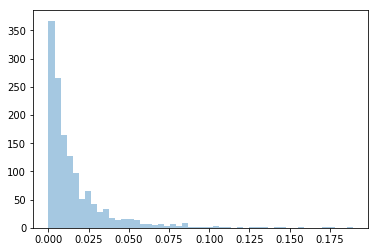

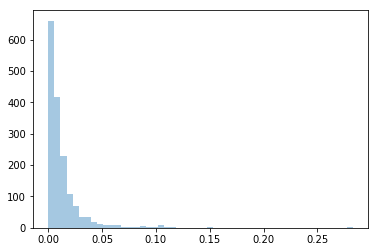

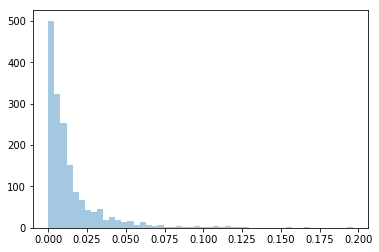

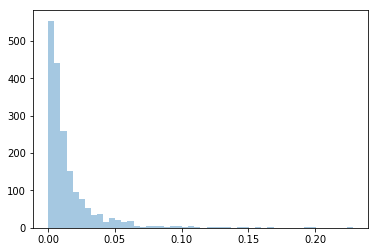

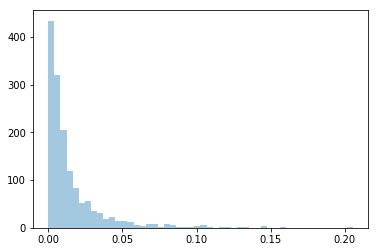

In [37]:
for i in range(5):
    dist = avg_distance(peakMP[i])
    sns.distplot(dist, kde=False)
    plt.show()


In [ ]:
sns.distplot(peakSize, kde=False, bins = 100)
print(np.average(peakSize))
print(scipy.stats.mode(peakSize))

In [39]:
snp_kbp = np.asarray(density) 

0.7949655509892052 0


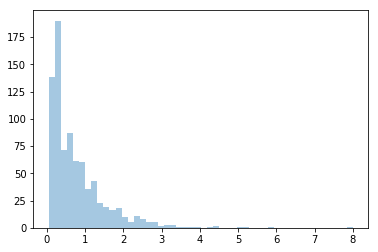

0.7077141464952194 1


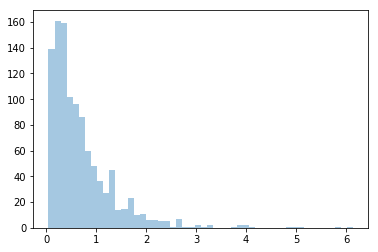

0.7740358935155821 2


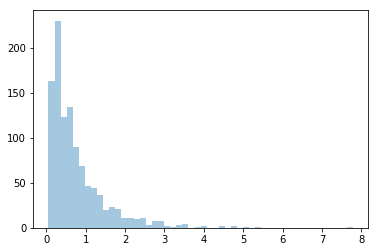

0.629947548710734 3


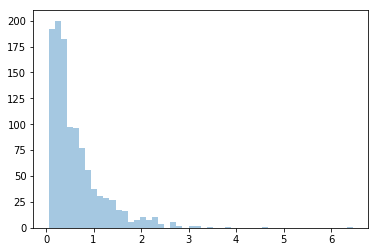

0.6145823498761027 4


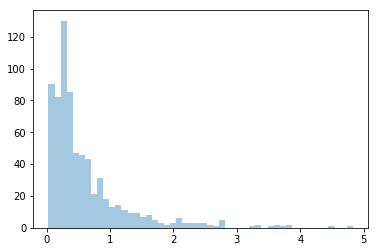

In [40]:
for i in range(5):
    sns.distplot( snp_kbp[i], kde=False, bins=50)
    print(np.average(snp_kbp[i]), i)
    plt.show()

### Plot of the SNP density across the peaks with SNPs

In [83]:

fig = plt.figure(figsize=(15,5))
sns.lineplot( np.asarray(sorted(positions[0])) / 1000000, density[0])
plt.ylabel('SNPs/100bp')
plt.xlabel('Mb')
plt.title('2L: Bulk ATACseq peak SNP density')
plt.axhline(np.average(density[0]), linestyle='--', color='red')
legend=['ATACseq Peaks', 'Peak Average ({0:.2f} SNPs/100bp)'.format(np.average(density[0]))]
plt.legend(legend)

plt.savefig('2L_atac_density.png', dpi=300)
plt.close()

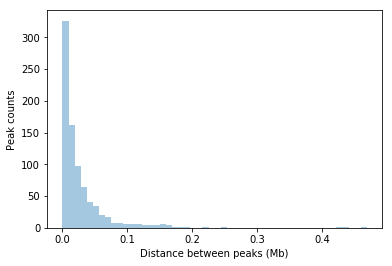

In [88]:
dist = avg_distance(positions[0])
sns.distplot(dist, kde=False)
plt.xlabel('Distance between peaks (Mb)')
plt.ylabel('Peak counts')
plt.show()

# Fix Bed files

In [40]:
import pandas as pd
import numpy as np

In [41]:
peaks = pd.read_csv('/home/iskander/Documents/Barbash_lab/mDrive/ATAC/B04_peaks.narrowPeak', sep='\t', header=None)

In [112]:
#chrom 2
chr2r = peaks.loc[peaks[0] == "chr2R"].values[:,1:3] + 23000000
chr2h = peaks.loc[peaks[0] == "chr2RHet"].values[:,1:3] + 23000000
chr2 = np.vstack((peaks.loc[peaks[0] == "chr2L"].values[:,1:3], 
                  peaks.loc[peaks[0] == "chr2LHet"].values[:,1:3],

                  chr2h, chr2r
                 ))

arm = np.asarray(['2' for p in range(chr2.shape[0])])
data1 = np.column_stack((arm, np.sort(chr2, axis=0 )))



In [114]:
#chrom 3
chr3r = peaks.loc[peaks[0] == "chr3R"].values[:,1:3] + 24500000
chr3h = peaks.loc[peaks[0] == "chr3RHet"].values[:,1:3] + 24500000
chr3 = np.vstack((peaks.loc[peaks[0] == "chr3L"].values[:,1:3], 
                  peaks.loc[peaks[0] == "chr3LHet"].values[:,1:3],
                chr3r, chr3h
                 ))

arm = np.asarray(['3' for p in range(chr3.shape[0])])
data2 = np.column_stack((arm, np.sort(chr3, axis=0)))

In [117]:
#chromX
X = np.vstack((peaks.loc[peaks[0] == "chrX"].values[:,1:3], 
                  peaks.loc[peaks[0] == "chrXHet"].values[:,1:3]))
arm=np.asarray(['X' for p in range(X.shape[0])])
data3 = np.column_stack((arm, np.sort(X, axis=0)))

In [118]:
bed_matrix = np.vstack((data1, data2, data3))

df = pd.DataFrame(bed_matrix)
df.to_csv(path_or_buf='/home/iskander/Documents/Barbash_lab/mDrive/dmel_ATAC_peaks.bed', sep='\t', 
                       columns=df,header=False, index=False)